# PyEmittance Bmad Demo

# Sim setup for pytao

In [4]:
import numpy as np
import os
import datetime 
import scipy.constants as constants
from pytao import Tao

import matplotlib
import matplotlib.pyplot as plt

In [6]:
init = '-init ./tao.init -noplot'
tao=Tao(init)  

In [7]:
# scan from 1 to -9 kG (machine units)
try:
    tao.cmd('snparticle 1500')
except RuntimeError:
    pass

try:
    tao.cmd('beamon')
except RuntimeError:
    pass

For transverse emittance measurement, we need to:
1. vary QE04 (QUAD:IN20:525)
2. measure beamsize for every QE04 value at the OTR2 screen
3. fit the beamsize vs quad strength data to get the emittance 

## Varying QE04 K1 from -12 to 0 1/m^2 (sim units) and getting beamsizes

In [50]:
# scanning values
quad_vals = np.linspace(-12, 0, 5)
# beamsizes list
x_sizes = []
y_sizes = []
# saving emittance predicted from bmad model
norm_emit_x = []
norm_emit_y = []

for i in range(len(quad_vals)):
    try:
        tao.cmd(f'set ele QE04 K1={quad_vals[i]}')
    except RuntimeError:
        pass
    
    print(tao.cmd('show ele QE04')[10])
    
    # bunch statistical data
    stats = tao.bunch_params('OTR2')
    x_sizes.append(stats["sigma_x"])
    y_sizes.append(stats["sigma_y"])
    norm_emit_x.append(stats["norm_emit_x"])
    norm_emit_y.append(stats["norm_emit_y"])

    4  K1                          = -1.2000000E+01 1/m^2    45  B1_GRADIENT                 =  5.4036996E+00 T/m
    4  K1                          = -9.0000000E+00 1/m^2    45  B1_GRADIENT                 =  4.0527747E+00 T/m
    4  K1                          = -6.0000000E+00 1/m^2    45  B1_GRADIENT                 =  2.7018498E+00 T/m
    4  K1                          = -3.0000000E+00 1/m^2    45  B1_GRADIENT                 =  1.3509249E+00 T/m
   10  FRINGE_TYPE                 =  None (1)               11  FRINGE_AT                   =  Both_Ends (3)


Text(0, 0.5, 'Beamsize (m)')

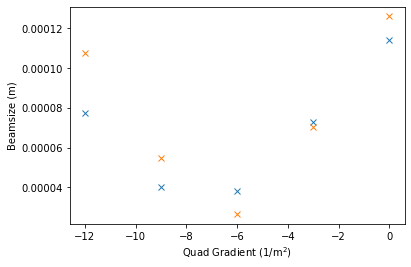

In [51]:
plt.plot(quad_vals, x_sizes, marker="x", linewidth=0)
plt.plot(quad_vals, y_sizes, marker="x", linewidth=0)
plt.xlabel(r"Quad Gradient (1/m$^2$)")
plt.ylabel("Beamsize (m)")

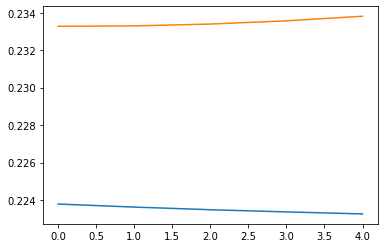

In [15]:
plt.plot(np.array(norm_emit_x)/1e-6)
plt.plot(np.array(norm_emit_y)/1e-6)

# Getting emittance using pyemittance package

In [63]:
# the sim quad vals are in T/m, but we need them in kG (set up to take kG since that's the machine unit)
# there are functions in pyemittance to do this
from pyemittance.optics import get_quad_field

quad_field_kG = get_quad_field(quad_vals)

In [20]:
# no error on sim measurement (but this would be non-zero on the machine)
x_sizes_err = np.asarray(x_sizes)*0
y_sizes_err = np.asarray(y_sizes)*0

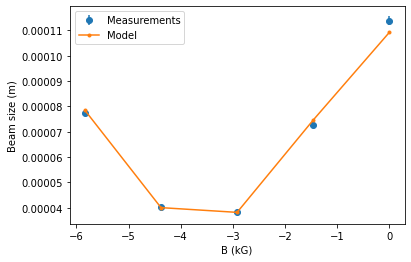

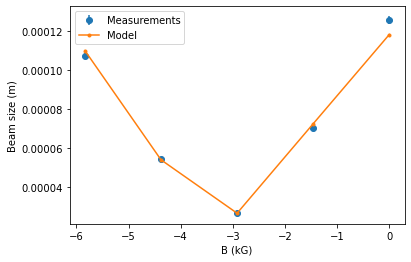

In [65]:
from pyemittance.emittance_calc import EmitCalc
# this is the main class for the emittance measurement 

# pass this info to the Emittance Calc class to start a measurement
ef = EmitCalc({'x': quad_field_kG, 'y': quad_field_kG},
              {'x': x_sizes, 'y': y_sizes},
              {'x': x_sizes_err, 'y': y_sizes_err}
              )
ef.plot = True

# get normalized transverse emittance, the out_dict is the results returned in a dictionary
out_dict = ef.get_emit()

### Returned dictionary output of pyemittance

In [66]:
out_dict 

{'nemitx': 2.1583252433314983e-07,
 'nemity': 2.1089024848400458e-07,
 'nemitx_err': 3.446757299528848e-09,
 'nemity_err': 4.0158327760268515e-09,
 'bmagx': 1.16556007968336,
 'bmagy': 1.3857156359913343,
 'bmagx_err': 0.01861351863024351,
 'bmagy_err': 0.02638719575357349,
 'opt_q_x': -4.376886589760936,
 'opt_q_y': -2.9179243931739567,
 'quadvalsx': array([-5.83584879, -4.37688659, -2.91792439, -1.4589622 ,  0.        ]),
 'beamsizesx': [7.71939923159646e-05,
  4.03960159655086e-05,
  3.81054984436276e-05,
  7.26370995851494e-05,
  0.000113857730743476],
 'quadvalsy': array([-5.83584879, -4.37688659, -2.91792439, -1.4589622 ,  0.        ]),
 'beamsizesy': [0.000107353736522507,
  5.4595853806668e-05,
  2.65273299632248e-05,
  7.01234748102133e-05,
  0.000125893639569768]}

In [73]:
# get geom mean of normalized emittances
# running this function adds the transverse normalized emittance to the output dictionary too
ef.get_gmean_emit()

print(f"Emittance from pyemittance: {out_dict['nemit']/1e-6:.2f} mm mrad")
print(f"Emittance from Bmad: {min(np.sqrt( np.array(norm_emit_x)*np.array(norm_emit_y) ))/1e-6:.2f} mm mrad")

Emittance from pyemittance: 0.21 mm mrad
Emittance from Bmad: 0.23 mm mrad


# =========================================================================

# How to get this machine ready
## Define I/O with machine 
To run this similarily to the machine, we define a function that communicates with the "machine" (which in this case was Bmad). The function needs to specify the new value for the quadrupole (or other beamline values, here called "config"), and return the beamsizes and the corresponding errors. Pyemittance is set up to be used with meters and kGauss units, so the Bmad units needed to be converted accordingly. 


In [95]:
# function to transform quad values from fields in kGauss to K1 in 1/m2
from pyemittance.optics import get_gradient, get_k1 

def get_bs_bmad(config, quad_val):
    '''PyEmittance requires a function to get the beamsize from a model
    to take two params and return the beamsizes and errors
    config: values of SOL, CQ, SQ in CU injector 
    quad_val: quadrupole value for measurement IN KG!
    '''
    config = [] # we are not changing anything in the injector here
    
    # convert to sim units
    quad_k1 = get_k1(get_gradient(quad_val))
    
    try:
        tao.cmd(f'set ele QE04 K1={quad_k1}')
    except RuntimeError:
        pass

    # bunch statistical data
    stats = tao.bunch_params('OTR2')
    x_size = stats["sigma_x"]
    y_size = stats["sigma_y"]

    # return xrms, yrms, xrms_err, yrms_err
    return x_size, y_size, 0, 0
    

## Now we put this in an all-in-one function that can run by defining how the beamsize is measured 
This was done for the machine and the sim in pyemittance.emit_eval_example

In [76]:
from pyemittance.emit_eval_example import eval_emit_surrogate # simulation evaluation function

In [77]:
eval_emit_surrogate?

Signature:
eval_emit_surrogate(
    get_bs_model,
    config,
    quad_init=[-6, -4, -2, 0],
    adapt_ranges=True,
    num_points=7,
    check_sym=True,
    infl_check=True,
    add_pnts=True,
    show_plots=False,
    add_noise=False,
    save_runs=False,
    calc_bmag=False,
)
Docstring: <no docstring>
File:      ~/bmad_quad_scan/pyemittance/emit_eval_example.py
Type:      function


In [96]:
# define values to scan on the "machine"
init_vals = [-5, -4, -3, -2, -1]

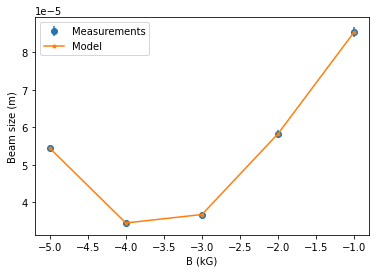

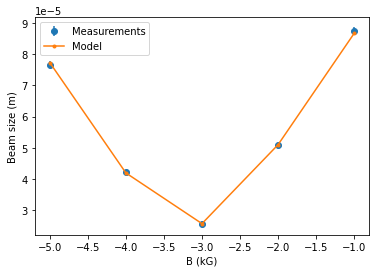

({'nemitx': 2.1404232640490705e-07,
  'nemity': 2.1264463508964542e-07,
  'nemitx_err': 2.9306847042284364e-09,
  'nemity_err': 3.183763436747894e-09,
  'bmagx': None,
  'bmagy': None,
  'bmagx_err': None,
  'bmagy_err': None,
  'opt_q_x': None,
  'opt_q_y': None,
  'quadvalsx': [-5, -4, -3, -2, -1],
  'beamsizesx': [5.44432076668192e-05,
   3.45540507578362e-05,
   3.68045956223544e-05,
   5.83085101390947e-05,
   8.5349388282595e-05],
  'quadvalsy': [-5, -4, -3, -2, -1],
  'beamsizesy': [7.66548958740404e-05,
   4.22282254989092e-05,
   2.57216840224761e-05,
   5.08254091968863e-05,
   8.72989253767821e-05],
  'nemit': 2.1334233614571262e-07,
  'nemit_err': 4.328487292709863e-09},
 5)

In [99]:
eval_emit_surrogate(
    get_bs_model=get_bs_bmad,
    config=None,
    quad_init=init_vals,
    adapt_ranges=False,
    check_sym=False,
    infl_check=False,
    add_pnts=False,
    show_plots=True,
)

## Making the equivalent functions for the machine with PV input/output

What needs to be defined is a function similar to **get_bs_bmad**.

This part is all done in the **beam_io.py** file.
The function in this case is in the class **MachineIO** that handles all I/O with the machine (see below example from beam_io.py).

In the __init__ function, all PVs are imported from the JSON files in the *config* folder. Then the **get_beamsizes_machine** is a simple function that is similar to **get_bs_bmad**: takes beamline and quadrupole value and returns the beamsizes and errors. Inside the function, setting the PVs is simple using the pyepics package, and the beamsizes are measured depending on what is being used.

- for OTR screens, the otrs_io.py is used to either fit the corresponding beam image and return the sizes, or it can pull the Matlab generated beamsizes from PVs (the option is called ProfMon since it's the profile monitor GUI in the control room that measures these and writes them to PVs).

In [101]:
class MachineIO():
    """Class for handling all machine I/O"""
    def __init__(self, name='LCLS', meas_type='OTRS'):
        # machine name: only LCLS or FACET are currently supported
        self.name = name
        # specify OTRS or WIRE scans
        self.meas_type = meas_type
        self.online = False
        self.use_profmon = False
        self.settle_time = 3 # sleep time in seconds

        # load info about PVs used in measurements (e.g. quad scan PV, image PV)
        self.dir, self.filename = path.split(__file__)
        self.CONFIG_PATH = path.join(self.dir, "configs")
        self.meas_pv_info = json.load(open(self.CONFIG_PATH + '/meas_pv_info.json'))

        self.meas_read_pv = PV(self.meas_pv_info['meas_device']['pv']['read'])
        #if self.online:
        # load info about settings to optimize
        self.opt_pv_info = json.load(open(self.CONFIG_PATH + '/opt_pv_info.json'))
        self.opt_pvs = self.opt_pv_info['opt_vars']
        self.meas_cntrl_pv = PV(self.meas_pv_info['meas_device']['pv']['cntrl'])
        self.sol_cntrl_pv = PV(self.opt_pvs[0])
        self.cq_cntrl_pv = PV(self.opt_pvs[1])
        self.sq_cntrl_pv = PV(self.opt_pvs[2])

    def get_beamsizes_machine(self, config, quad_val):
        """Fn that pyemittance.observer calls
        Takes quad value as input,
        Returns xrms, yrms, xrms_err, yrms_err
        """
        if self.online and quad_val is not None:
            self.setquad(quad_val)
            self.setinjector(config)
            time.sleep(self.settle_time)
            
        else:
            print("Not setting online values.")

        if self.meas_type == 'OTRS':
            return get_beamsizes_otrs(self.use_profmon)

        elif self.meas_type == 'WIRE':
            if self.online:
                return get_beamsizes_wire(self.online)
            else:
                print("Not running wire scans.")

        else:
            raise NotImplementedError('No valid measurement type defined.')